# Test du code Pytorch

In [3]:
import sys
sys.path.append('../src')
import shutil
import yaml
import py7zr
import os
import s3fs
from satellite_image import SatelliteImage
from labeler import RILLabeler
from labeler import BDTOPOLabeler
from labeled_satellite_image import SegmentationLabeledSatelliteImage
from utils import *
from filter import *
import matplotlib.pyplot as plt
import numpy as np
import rasterio.plot as rp
import re
from datetime import datetime
from tqdm import tqdm

In [4]:
update_storage_access()

## Téléchargement des données Pléiades

In [5]:
environment = get_environment()

bucket = environment["bucket"]
path_s3_pleiades_data = environment["sources"]["PLEIADES"]
path_s3_bdtopo_data = environment["sources"]["BDTOPO"][2022]["guyane"]
path_local_pleiades_data = environment["local-path"]["PLEIADES"]
path_local_bdtopo_data = environment["local-path"]["BDTOPO"][2022]["guyane"]

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

On télécharge les fichiers depuis s3 (à mettre dans le setup.sh?)

In [6]:
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data}",
        lpath=f"../{path_local_pleiades_data}",
        recursive=True)

In [5]:
fs.download(
        rpath=f"{bucket}/{path_s3_bdtopo_data}",
        lpath=f"../{path_local_bdtopo_data}",
        recursive=True)

## Découpage et filtrage des images

In [7]:
images_paths = [f"../{path_local_pleiades_data}/16bits/ORT_2022072050325085_U22N/" + p for p in os.listdir(f"../{path_local_pleiades_data}/16bits/ORT_2022072050325085_U22N/")]

In [8]:
date = datetime.strptime(re.search(r'ORT_(\d{8})', images_paths[0]).group(1), '%Y%m%d')

On importes les `SatelliteImage` dans une liste.

In [9]:
list_images = [
     SatelliteImage.from_raster(
        filename,
        dep = "973",
        date = date, 
        n_bands = 4
    ) for filename in tqdm(images_paths)]

100%|██████████| 240/240 [00:33<00:00,  7.11it/s]


On découpe les images initialement de dimension 2000 en plusieurs image de dimension `dim`. On ne garde ensuite que les images qui sont pertinentes à l'aide de la méthode `filter_images`. Une image contenant moins de 50% de pixels non noirs n'est pas retenue.

In [10]:
dim = 250

In [11]:
splitted_list_images = [im for sublist in tqdm(list_images) for im in sublist.split(250) if not is_too_black(im)]

100%|██████████| 240/240 [00:09<00:00, 26.20it/s]


In [12]:
len(splitted_list_images)

13254

On peut représenter graphiquement nos images grâce à la méthode `plot` :

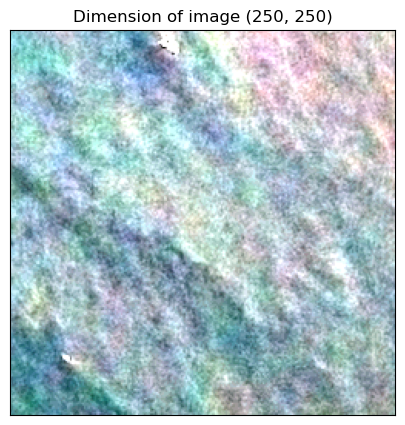

In [13]:
splitted_list_images[2793].plot([0, 1, 2]) # RGB (3 premières bandes)

On peut représenter l'image infrarouge : 

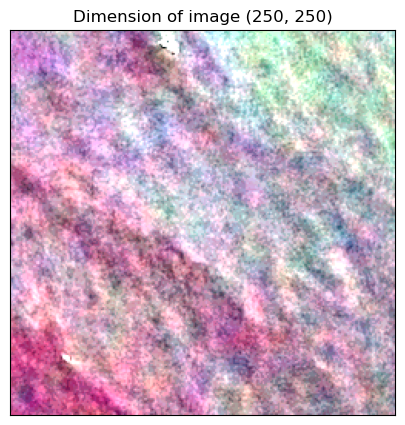

In [14]:
splitted_list_images[2793].plot([3, 0, 1]) # RGB (Infrarouge, rouge, vert)

Ou bien qu'une seule bande :

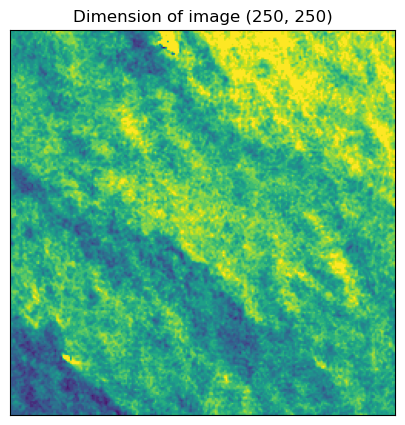

In [15]:
splitted_list_images[2793].plot([0]) # Une bande

## Labélisation avec le RIL

On définit un `labeler` incluant la taille des buffers que l'on souhaite ainsi que la forme de ceux-ci.

In [16]:
labeler_RIL = RILLabeler(date, dep="973", buffer_size=6, cap_style=3)

A l'aide de notre `labeler` on créer une `SegmentationLabeledSatelliteImage`.

In [91]:
list_labeled_images = []
for sat_im in tqdm(splitted_list_images[:30]):
    sat_im.normalize()
    list_labeled_images.append(
        SegmentationLabeledSatelliteImage(
            sat_im,
            labeler_RIL.create_segmentation_label(sat_im),
            "RIL",
            date
        )
    )

 17%|█▋        | 5/30 [00:00<00:00, 39.73it/s]

100%|██████████| 30/30 [00:00<00:00, 38.12it/s]


In [108]:
splitted_list_images[0].to_tensor().shape

torch.Size([4, 250, 250])

In [109]:
splitted_list_images[0].to_tensor([0, 1, 2]).shape

torch.Size([3, 250, 250])

### Dataset

In [110]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
from dataset import SatelliteDataset

In [114]:
from dataset import SatelliteDataModule

data_module = SatelliteDataModule(
    train_data=list_labeled_images[:20],
    test_data=list_labeled_images[20:],
    num_workers=0
)

In [115]:
train_dataloader = data_module.train_dataloader()

In [116]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([8, 4, 250, 250])
Labels batch shape: torch.Size([8, 250, 250])


In [117]:
img = train_features[0].squeeze()

In [118]:
img.shape

torch.Size([4, 250, 250])

In [ ]:
np.transpose(img[[0, 1, 2], :, :], (1, 2, 0))

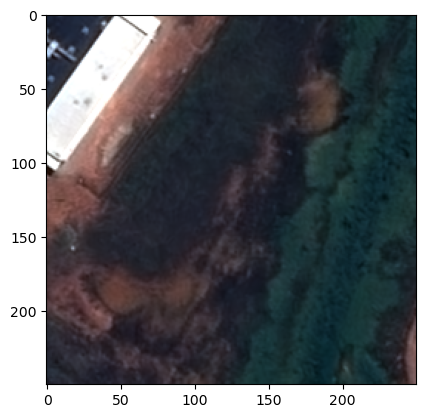

In [122]:
plt.imshow(np.transpose(img[[0, 1, 2], :, :], (1, 2, 0)))
plt.show()

In [124]:
label = train_labels[0]
label.shape

torch.Size([250, 250])

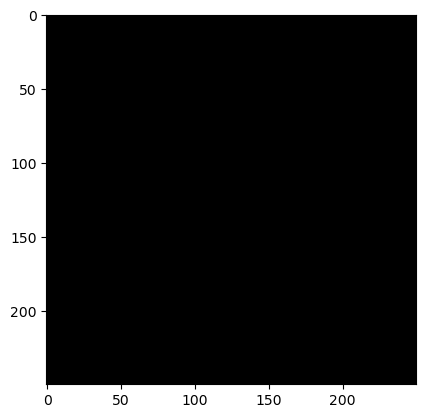

In [125]:
plt.imshow(label, cmap="gray")
plt.show()

In [126]:
for label in train_labels:
    print(label.sum())

tensor(0., dtype=torch.float64)
tensor(625., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(1250., dtype=torch.float64)


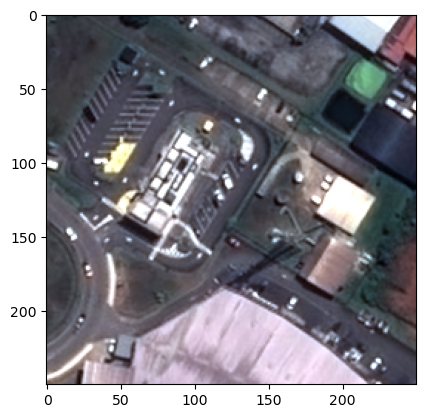

In [129]:
img = train_features[7].squeeze()

plt.imshow(np.transpose(img[[0, 1, 2], :, :], (1, 2, 0)))
plt.show()

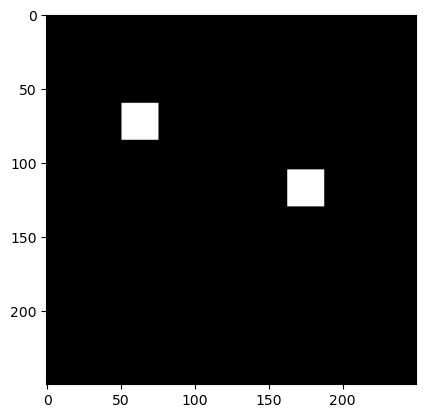

In [130]:
label = train_labels[7]
plt.imshow(label, cmap="gray")
plt.show()

### Test avec BDTOPO

In [133]:
labeler_BDTOPO = BDTOPOLabeler(date, dep="973")

In [135]:
list_labeled_images = [
   SegmentationLabeledSatelliteImage(
      sat_im,
      labeler_BDTOPO.create_segmentation_label(sat_im),
      "BDTOPO",
      date
   ) for sat_im in tqdm(splitted_list_images[:30])]

100%|██████████| 30/30 [00:01<00:00, 24.83it/s]


In [136]:
data_module = SatelliteDataModule(
    train_data=list_labeled_images[:20],
    test_data=list_labeled_images[20:],
    num_workers=0
)

In [137]:
train_dataloader = data_module.train_dataloader()

In [138]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([8, 4, 250, 250])
Labels batch shape: torch.Size([8, 250, 250])


In [139]:
img = train_features[0].squeeze()

In [140]:
img.shape

torch.Size([4, 250, 250])

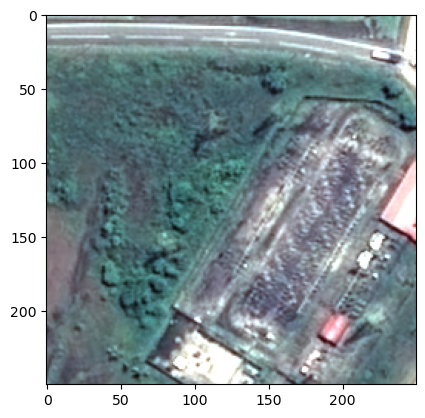

In [141]:
plt.imshow(np.transpose(img[[0, 1, 2], :, :], (1, 2, 0)))
plt.show()

In [142]:
label = train_labels[0]
label.shape

torch.Size([250, 250])

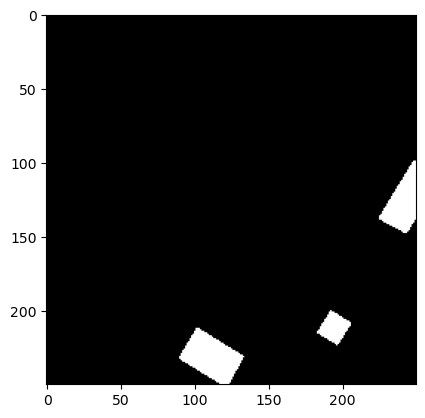

In [143]:
plt.imshow(label, cmap="gray")
plt.show()

### Add transforms

In [148]:
!pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 20.7 MB/s eta 0:00:0000:0100:01


In [149]:
import albumentations as album
from albumentations.pytorch.transforms import ToTensorV2

In [183]:
image_size = (250, 250)
# Some additional normalization is done here
transforms_augmentation = album.Compose(
    [
        album.Resize(300, 300, always_apply=True),
        album.RandomResizedCrop(
            *image_size, scale=(0.7, 1.0), ratio=(0.7, 1)
        ),
        album.HorizontalFlip(),
        album.VerticalFlip(),
        album.Normalize(),
        ToTensorV2(),
    ]
)

In [184]:
transforms_preprocessing = album.Compose(
    [
        album.Resize(*image_size, always_apply=True),
        album.Normalize(),
        ToTensorV2(),
    ]
)

In [185]:
data_module = SatelliteDataModule(
    train_data=list_labeled_images[:20],
    test_data=list_labeled_images[20:],
    transforms_augmentation=transforms_augmentation,
    transforms_preprocessing=transforms_preprocessing,
    num_workers=0,
    bands_indices=[0, 1, 2]
)

train_dataloader = data_module.train_dataloader()
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([8, 3, 250, 250])
Labels batch shape: torch.Size([8, 250, 250])


In [186]:
test_dataloader = data_module.test_dataloader()
test_features, test_labels = next(iter(test_dataloader))